#0. Setting Everything Up

Mount Drive




In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


Install Libaries

In [ ]:
!pip install tslearn

     |████████████████████████████████| 778kB 2.6MB/s 


Required Libraries

In [ ]:
%matplotlib inline

import matplotlib
import numpy as np
import scipy as sci 
from sklearn.cluster import KMeans
import tslearn.clustering as ts
import pandas as pd
import matplotlib.pyplot as plt
import os
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw
from sklearn.decomposition import PCA
import seaborn as sns
from random import seed
from random import randint
import random
import zipfile
import dask.dataframe as dd


# Dimension reduction and clustering libraries
import umap
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.cluster.k_means_ module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.cluster. Anything that cannot be imported from sklearn.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


**Code for collecting GIFGIF Dataset**

Do Not need to run. We used the code from Assignment 3 to collect a dataset for 4 emotions. Manually selected GIF samples from GIPHY were added to the dataset as well.

In [ ]:
# Code originally by TA Payam Jome Yazdian from CMPT 419
# Modified for project use

import json
import requests
import urllib.parse
from pathlib import Path
import os

print("Replace intended downloaded GIF emotions in python script's \"target_metrics\".")
API_ENDPOINT = 'https://www.qnt.io/api/displaymetrics?pID=gifgif&mode=all&key=54a309ac1c61be23aba0da3f'
#Make a request: 
r=requests.get(API_ENDPOINT)

#Parse the response using JSON
output_json = json.loads(r.text)

Dic = []
print("=========================================")
print("Metrics and mID from enpoint:")
for obj in output_json:
  Dic.append( [obj[('metric')], obj[('mID')]] )
  print("Metric: " + obj[('metric')] + '______' + " mID: " + obj[('mID')])
print("=========================================")

BaseFolder = './dataset' # Where the downloaded GIFs will be saved
sample_count = 200  # Number of GIFs to download for a specific metric
target_metrics = ["happiness", "sadness", "fear", "surprise"] # Only metrics specified in the array will be downloaded

print("Target GIFs: " + ", ".join(target_metrics))
print("GIF count for each metric: " + str(sample_count))
for obj in Dic:

  Metric, mID = obj
  if str(Metric) in target_metrics:
    
    # Check if the metric folder does not exist in the base folder, then create it.
    directory = str(BaseFolder) + '/' + str(Metric)
    print("Downloading " + str(Metric) +
           " GIFs into " + directory)
    if not os.path.exists(directory):
      os.makedirs(directory)

    # Create request URL 
    API_ENDPOINT = "https://www.qnt.io/api/results?pID=gifgif&mID={}&limit={}&key=54a309ac1c61be23aba0da3f".format(mID, sample_count)
    r=requests.get(API_ENDPOINT)
    output_json = json.loads(r.text)

    # Download gif file
    for result in output_json['results']:
      embedLink = result['content_data']['embedLink']
      r = requests.get(embedLink, allow_redirects=True)
      open(directory + '/' + f"{result['rank']}.{result['content_type']}", 'wb').write(r.content)

print("Finished")


# 1. Preprocessing the Data


Extracting Data from CSVs

In [ ]:
directory = './pose_csv_outputs'
if not os.path.exists(directory):
  with zipfile.ZipFile("/content/drive/My Drive/pose_csv_outputs.zip", 'r') as zip_ref:
    zip_ref.extractall()

emotions = os.listdir(directory)
df_poses = pd.DataFrame()
df_faces = pd.DataFrame()
df_lhands = pd.DataFrame()
df_rhands = pd.DataFrame()

sample_label = 'sample'
emotion_label = 'emotion'

for emotion in emotions:
  folder_path = f"{directory}/{emotion}"
  samples = os.listdir(folder_path)
  print(samples)
  for sample in samples:
    file_path = f"{folder_path}/{sample}"
    # Pose
    df_pose = pd.read_csv(f"{file_path}/pose.csv")
    df_pose.drop("Unnamed: 0", axis=1, inplace=True)
    df_pose[sample_label] = sample
    df_pose[emotion_label] = emotion
    if df_pose.empty:
      continue
    if df_poses.empty:
      df_poses = df_pose
    else:
      df_poses = pd.concat([df_poses, df_pose])
    
    # Face
    df_face = pd.read_csv(file_path + "/face.csv")
    df_face.drop("Unnamed: 0", axis=1, inplace=True)
    df_face[sample_label] = sample
    df_face[emotion_label] = emotion
    if df_faces.empty:
      df_faces = df_face
    else:
      df_faces = pd.concat([df_faces, df_face])

    # Left Hand
    df_lhand = pd.read_csv(file_path + "/hand_left.csv")
    df_lhand.drop("Unnamed: 0", axis=1, inplace=True)
    df_lhand[sample_label] = sample
    df_lhand[emotion_label] = emotion
    if df_lhands.empty:
      df_lhands = df_lhand
    else:
      df_lhands = pd.concat([df_lhands, df_lhand])

    # Right Hand
    df_rhand = pd.read_csv(file_path + "/hand_right.csv")
    df_rhand.drop("Unnamed: 0", axis=1, inplace=True)
    df_rhand[sample_label] = sample
    df_rhand[emotion_label] = emotion
    if df_rhands.empty:
      df_rhands = df_rhand
    else:
      df_rhands = pd.concat([df_rhands, df_rhand])

print(df_poses)
print(df_faces)
print(df_lhands)
print(df_rhands)

['209', '210', '207', '80', '34', '218', '5', '150', '10', '15', '211', '73', '132', '146', '91', '3', '81', '188', '114', '123', '204', '144', '28', '203', '124', '24', '82', '212', '164', '99', '20', '53', '217', '27', '106', '76', '160', '6', '88', '169', '4', '22', '108', '101', '119', '75', '151', '94', '83', '185', '161', '133', '206', '166', '219', '220', '115', '41', '56', '104', '9', '117', '131', '134', '40', '215', '116', '70', '121', '93', '60', '8', '39', '136', '103', '14', '137', '216', '173', '21', '69', '37', '46', '31', '13', '159', '2', '107', '189', '7', '68', '65', '45', '36', '110', '148', '23', '84', '122', '66', '87', '97', '19', '139', '109', '205', '214', '62', '44', '48', '200', '202', '127', '0', '163', '157', '16', '25', '155', '213', '1', '135', '196', '201', '38', '153', '208', '197', '12', '58', '26', '64', '96', '130', '145', '92']
['209', '207', '218', '102', '240', '10', '15', '211', '73', '223', '156', '175', '234', '154', '91', '188', '114', '147', 

Functions to clean up columns


In [ ]:
frame_label = 'frame'
def preprocess(df):

  column_labels = list(df.columns)
  filtered_labels = []

  df.index.name = frame_label
  df.reset_index(level=0, inplace=True)

  return df.drop(filtered_labels, axis=1)

#Combine all filtered df into one merged df
#Outer Join Lhand and Rhand on Emotion, Sample and Frame
def combine_openpose_dfs(pose_df, face_df, lhand_df, rhand_df):
  openpose_df = pd.DataFrame()
  openpose_df = pd.merge(pose_df, face_df, how='outer', on=[emotion_label, sample_label, frame_label], suffixes=['_pose','_face'])              
  openpose_df = pd.merge(openpose_df, lhand_df, how='outer', on=[emotion_label, sample_label, frame_label], suffixes=['','_lhand'])
  openpose_df = pd.merge(openpose_df, rhand_df, how='outer', on=[emotion_label, sample_label, frame_label], suffixes=['','_rhand'])

  return openpose_df

#Remove Confidence Columns, and lower body columns
def Second_preprocess(df):

  column_labels = list(df.columns)
  filtered_labels = []

  for label in column_labels:
    if(label.startswith('c_')):
      filtered_labels.append(label)
    if(label.endswith('Toe')):
      filtered_labels.append(label)
    if(label.endswith('Heel')):
      filtered_labels.append(label)
    if(label.endswith('Hip')):
      filtered_labels.append(label)
    if(label.endswith('Knee')):
      filtered_labels.append(label)
    if(label.endswith('Ankle')):
      filtered_labels.append(label)

  return df.drop(filtered_labels, axis=1)

Preprocessing the dataframes 


In [ ]:
processed_df_poses = preprocess(df_poses)
processed_df_faces = preprocess(df_faces)
processed_df_lhands = preprocess(df_lhands)
processed_df_rhands = preprocess(df_rhands)
#rint(processed_df_lhands)
#print(processed_df_rhands)
#print(processed_df_poses)
#print(processed_df_faces)
#display(processed_df_lhands)

Concatenate all the dataframes into one large dataframe

In [18]:
#Combine all filtered df into one merged df
#Outer Join Lhand and Rhand on Emotion, Sample and Frame
combined_df = combine_openpose_dfs(processed_df_poses, processed_df_faces, processed_df_lhands, processed_df_rhands)
display(combined_df)

,frame,x_Nose,y_Nose,c_Nose,x_Neck,y_Neck,c_Neck,x_RShoulder,y_RShoulder,c_RShoulder,x_RElbow,y_RElbow,c_RElbow,x_RWrist,y_RWrist,c_RWrist,x_LShoulder,y_LShoulder,c_LShoulder,x_LElbow,y_LElbow,c_LElbow,x_LWrist,y_LWrist,c_LWrist,x_MidHip,y_MidHip,c_MidHip,x_RHip,y_RHip,c_RHip,x_RKnee,y_RKnee,c_RKnee,x_RAnkle,y_RAnkle,c_RAnkle,x_LHip,y_LHip,c_LHip,...,c_7_rhand,x_8_rhand,y_8_rhand,c_8_rhand,x_9_rhand,y_9_rhand,c_9_rhand,x_10_rhand,y_10_rhand,c_10_rhand,x_11_rhand,y_11_rhand,c_11_rhand,x_12_rhand,y_12_rhand,c_12_rhand,x_13_rhand,y_13_rhand,c_13_rhand,x_14_rhand,y_14_rhand,c_14_rhand,x_15_rhand,y_15_rhand,c_15_rhand,x_16_rhand,y_16_rhand,c_16_rhand,x_17_rhand,y_17_rhand,c_17_rhand,x_18_rhand,y_18_rhand,c_18_rhand,x_19_rhand,y_19_rhand,c_19_rhand,x_20_rhand,y_20_rhand,c_20_rhand
0,0,255.790,86.0779,0.845103,251.270,171.6240,0.754007,180.6970,168.6730,0.642776,162.6690,293.281,0.865857,168.6570,225.729,0.640552,321.844,171.6540,0.658086,351.835,293.313,0.841734,341.396,222.724,0.743444,254.255,366.904,0.492476,210.7250,368.375,0.480886,0.0,0.0,0.0,0.0,0.0,0.0,294.760,368.374,0.488657,...,0.051738,176.6370,190.9660,0.025926,173.8660,182.1900,0.236908,179.8710,181.7290,0.061371,178.4850,193.2750,0.038042,178.0230,192.8140,0.018212,166.01400,177.1100,0.191842,178.48500,175.7240,0.033486,176.1760,200.6660,0.028719,179.8710,205.7460,0.024380,160.47200,172.029,0.163324,158.62400,175.7240,0.046731,178.02300,200.6660,0.047462,176.17600,207.5940,0.039360
1,1,257.176,86.0582,0.845711,249.757,164.2200,0.768782,185.2280,165.6990,0.643576,168.6940,290.265,0.765615,174.7100,177.682,0.360334,317.285,164.1520,0.676983,350.381,285.780,0.770976,333.867,185.221,0.648463,255.714,368.381,0.485511,210.7790,368.390,0.464310,0.0,0.0,0.0,0.0,0.0,0.0,294.788,368.390,0.474159,...,0.361477,190.0640,105.4950,0.290608,182.2270,127.1610,0.246470,185.4540,116.0980,0.330704,188.6810,109.6440,0.377306,190.0640,104.1120,0.418028,178.53900,124.3950,0.322115,182.22700,116.5590,0.315593,185.4540,110.1050,0.263032,186.3760,105.0340,0.264728,174.39100,123.934,0.372001,178.53900,115.6370,0.201881,181.76600,109.6440,0.265968,184.53200,106.4170,0.189335
2,2,257.215,86.0455,0.856817,251.250,162.6820,0.788173,186.7200,164.1600,0.642545,173.1760,281.275,0.848406,183.7110,161.173,0.695691,315.791,162.6430,0.674532,347.389,278.254,0.753691,339.848,207.678,0.089512,255.748,366.879,0.496514,212.2140,366.884,0.452953,0.0,0.0,0.0,0.0,0.0,0.0,294.795,366.885,0.477285,...,0.643328,190.1360,76.3283,0.676923,179.8160,123.5050,0.688598,177.3590,99.9167,0.753317,185.7140,87.1396,0.713339,189.6450,75.8368,0.773723,178.34200,129.8940,0.712304,180.79900,106.7970,0.646140,185.2220,95.0024,0.481383,188.6620,83.2082,0.510947,180.79900,134.808,0.690764,184.73100,120.5570,0.841136,186.69600,111.2190,0.712115,189.15400,103.3570,0.684335
3,3,257.200,84.6051,0.852749,249.789,161.1670,0.800733,183.6790,162.6640,0.721833,176.2310,269.257,0.793604,189.7330,150.637,0.775629,318.831,159.6790,0.644367,344.412,264.797,0.777175,318.804,147.652,0.807888,254.289,366.876,0.477865,210.7720,366.882,0.460338,0.0,0.0,0.0,0.0,0.0,0.0,294.770,366.886,0.469288,...,0.643676,189.3230,57.9634,0.570792,181.0500,109.0590,0.811342,179.1040,81.8082,0.621752,187.3760,66.7227,0.796237,192.2430,55.0436,0.816611,182.99700,111.0060,0.701452,181.05000,86.1878,0.729500,188.8360,73.0489,0.738076,193.7030,60.8831,0.640607,186.40300,114.412,0.620211,187.86300,99.8134,0.689551,191.75600,87.1611,0.876332,195.64900,78.4018,0.703812
4,4,257.177,83.0941,0.839537,246.766,159.6310,0.820937,183.7030,161.1990,0.726896,185.2250,258.805,0.857857,198.6430,138.590,0.795742,306.809,153.6730,0.695157,342.824,255.735,0.814336,312.803,131.154,0.752282,257.200,366.872,0.484850,213.7040,366.879,0.444908,0.0,0.0,0.0,0.0,0.0,0.0,294.857,366.870,0.458369,...,0.620198,194.1960,45.6695,0.573120,187.2940,95.9606,0.745766,185.3210,72.7873,0.870646,192.7170,57.5027,0.921055,196.6610,44.6834,0.751758,191.23800,97.4398,0.673658,190.25200,80.6761,0.431639,197.155

Add String Columns

In [19]:
n_df_poses = combined_df
n_df_poses = Second_preprocess(n_df_poses)
cols_at_end = ['sample', 'emotion', 'frame']
n_df_poses = n_df_poses[[c for c in n_df_poses if c not in cols_at_end] + [c for c in cols_at_end if c in n_df_poses]]

happiness_count = len(n_df_poses[n_df_poses.emotion == "happiness"])
fear_count = len(n_df_poses[n_df_poses.emotion == "fear"])
sadness_count = len(n_df_poses[n_df_poses.emotion == "sadness"])
surprise_count = len(n_df_poses[n_df_poses.emotion == "surprise"])

print (happiness_count)
print (fear_count)
print (sadness_count)
print (surprise_count)
n_df_poses

3978
4534
4321
4367


,x_Nose,y_Nose,x_Neck,y_Neck,x_RShoulder,y_RShoulder,x_RElbow,y_RElbow,x_RWrist,y_RWrist,x_LShoulder,y_LShoulder,x_LElbow,y_LElbow,x_LWrist,y_LWrist,x_REye,y_REye,x_LEye,y_LEye,x_REar,y_REar,x_LEar,y_LEar,x_0,y_0,x_1,y_1,x_2,y_2,x_3,y_3,x_4,y_4,x_5,y_5,x_6,y_6,x_7,y_7,...,y_2_rhand,x_3_rhand,y_3_rhand,x_4_rhand,y_4_rhand,x_5_rhand,y_5_rhand,x_6_rhand,y_6_rhand,x_7_rhand,y_7_rhand,x_8_rhand,y_8_rhand,x_9_rhand,y_9_rhand,x_10_rhand,y_10_rhand,x_11_rhand,y_11_rhand,x_12_rhand,y_12_rhand,x_13_rhand,y_13_rhand,x_14_rhand,y_14_rhand,x_15_rhand,y_15_rhand,x_16_rhand,y_16_rhand,x_17_rhand,y_17_rhand,x_18_rhand,y_18_rhand,x_19_rhand,y_19_rhand,x_20_rhand,y_20_rhand,sample,emotion,frame
0,255.790,86.0779,251.270,171.6240,180.6970,168.6730,162.6690,293.281,168.6570,225.729,321.844,171.6540,351.835,293.313,341.396,222.724,237.756,72.5822,264.786,66.6558,221.244,83.0897,281.288,77.0386,220.769,75.8590,222.467,84.3518,223.486,91.8255,226.204,99.6389,229.601,107.4520,234.697,113.2270,240.472,118.6630,247.946,123.0790,...,212.213,183.1040,198.8180,181.2560,204.8220,185.4130,187.7330,181.2560,188.6570,180.3320,193.2750,176.6370,190.9660,173.8660,182.1900,179.8710,181.7290,178.4850,193.2750,178.0230,192.8140,166.01400,177.1100,178.48500,175.7240,176.1760,200.6660,179.8710,205.7460,160.47200,172.029,158.62400,175.7240,178.02300,200.6660,176.17600,207.5940,209,surprise,0
1,257.176,86.0582,249.757,164.2200,185.2280,165.6990,168.6940,290.265,174.7100,177.682,317.285,164.1520,350.381,285.780,333.867,185.221,237.781,72.5728,266.275,66.6424,221.288,83.0960,281.335,77.0467,221.518,75.0732,222.510,83.6703,224.494,91.6060,226.808,99.5418,229.784,106.4860,235.075,113.4290,240.696,119.0500,247.970,122.6880,...,152.054,199.2830,134.9980,203.8930,120.7080,186.8370,129.4660,190.5250,119.3250,192.8300,112.8710,190.0640,105.4950,182.2270,127.1610,185.4540,116.0980,188.6810,109.6440,190.0640,104.1120,178.53900,124.3950,182.22700,116.5590,185.4540,110.1050,186.3760,105.0340,174.39100,123.934,178.53900,115.6370,181.76600,109.6440,184.53200,106.4170,209,surprise,1
2,257.215,86.0455,251.250,162.6820,186.7200,164.1600,173.1760,281.275,183.7110,161.173,315.791,162.6430,347.389,278.254,339.848,207.678,240.725,72.5600,267.750,68.0480,221.298,83.0617,281.349,77.0859,221.607,74.7826,223.222,83.1816,224.514,91.2574,226.452,99.0103,230.329,106.1170,234.851,113.2240,240.989,118.3920,247.450,122.2690,...,131.368,200.4560,115.1510,203.8960,101.3910,181.2910,121.5390,177.8510,99.4252,186.2050,87.1396,190.1360,76.3283,179.8160,123.5050,177.3590,99.9167,185.7140,87.1396,189.6450,75.8368,178.34200,129.8940,180.79900,106.7970,185.2220,95.0024,188.6620,83.2082,180.79900,134.808,184.73100,120.5570,186.69600,111.2190,189.15400,103.3570,209,surprise,2
3,257.200,84.6051,249.789,161.1670,183.6790,162.6640,176.2310,269.257,189.7330,150.637,318.831,159.6790,344.412,264.797,318.804,147.652,239.260,69.6063,267.753,66.6511,221.244,80.1130,282.726,77.0764,222.426,73.7633,223.083,82.3096,225.055,90.1985,227.028,98.4161,230.643,105.6480,235.903,112.2220,241.162,118.1380,248.722,122.7400,...,119.765,202.4620,102.2470,203.9220,90.5675,183.9700,106.1400,179.5900,83.7547,184.4570,67.6959,189.3230,57.9634,181.0500,109.0590,179.1040,81.8082,187.3760,66.7227,192.2430,55.0436,182.99700,111.0060,181.05000,86.1878,188.8360,73.0489,193.7030,60.8831,186.40300,114.412,187.86300,99.8134,191.75600,87.1611,195.64900,78.4018,209,surprise,3
4,257.177,83.0941,246.766,159.6310,183.7030,161.1990,185.2250,258.805,198.6430,138.590,306.809,153.6730,342.824,255.735,312.803,131.154,239.247,69.5476,267.781,66.6276,222.669,80.0878,281.359,77.1042,222.661,74.7538,223.634,82.8621,224.932,90.9704,227.526,99.0787,230.445,106.8630,235.635,113.9980,241.797,119.5120,248.932,124.0520,...,100.891,204.0570,91.0301,204.0570,86.5927,185.3210,93.4954,182.8560,72.7873,188.2800,57.0096,194.1960,45.6695,187.2940,95.9606,185.3210,72.7873,192.7170,57.5027,196.6610,44.6834,191.23800,97.4398,190.25200,80.6761,197.1550,69.3359,201.0990,60.9540

Remove string columns and convert to numpy

In [20]:
X = n_df_poses.drop([emotion_label, sample_label ,frame_label], axis=1)
X = X.to_numpy()

# K-means Clustering 

Finding the optimal number of clusters using the elbow method found from https://medium.com/analytics-vidhya/how-to-determine-the-optimal-k-for-k-means-708505d204eb

/usr/local/lib/python3.6/dist-packages/tslearn/utils.py:91: UserWarning: 2-Dimensional data passed. Assuming these are 17200 1-dimensional timeseries
  '{} 1-dimensional timeseries'.format(X.shape[0]))


The shape of the cluster centers for k = 1
(1, 248, 1)


/usr/local/lib/python3.6/dist-packages/tslearn/utils.py:91: UserWarning: 2-Dimensional data passed. Assuming these are 17200 1-dimensional timeseries
  '{} 1-dimensional timeseries'.format(X.shape[0]))


The shape of the cluster centers for k = 2
(2, 248, 1)


/usr/local/lib/python3.6/dist-packages/tslearn/utils.py:91: UserWarning: 2-Dimensional data passed. Assuming these are 17200 1-dimensional timeseries
  '{} 1-dimensional timeseries'.format(X.shape[0]))


The shape of the cluster centers for k = 3
(3, 248, 1)


/usr/local/lib/python3.6/dist-packages/tslearn/utils.py:91: UserWarning: 2-Dimensional data passed. Assuming these are 17200 1-dimensional timeseries
  '{} 1-dimensional timeseries'.format(X.shape[0]))


The shape of the cluster centers for k = 4
(4, 248, 1)


/usr/local/lib/python3.6/dist-packages/tslearn/utils.py:91: UserWarning: 2-Dimensional data passed. Assuming these are 17200 1-dimensional timeseries
  '{} 1-dimensional timeseries'.format(X.shape[0]))


The shape of the cluster centers for k = 5
(5, 248, 1)


/usr/local/lib/python3.6/dist-packages/tslearn/utils.py:91: UserWarning: 2-Dimensional data passed. Assuming these are 17200 1-dimensional timeseries
  '{} 1-dimensional timeseries'.format(X.shape[0]))


The shape of the cluster centers for k = 6
(6, 248, 1)


/usr/local/lib/python3.6/dist-packages/tslearn/utils.py:91: UserWarning: 2-Dimensional data passed. Assuming these are 17200 1-dimensional timeseries
  '{} 1-dimensional timeseries'.format(X.shape[0]))


The shape of the cluster centers for k = 7
(7, 248, 1)


/usr/local/lib/python3.6/dist-packages/tslearn/utils.py:91: UserWarning: 2-Dimensional data passed. Assuming these are 17200 1-dimensional timeseries
  '{} 1-dimensional timeseries'.format(X.shape[0]))


The shape of the cluster centers for k = 8
(8, 248, 1)


/usr/local/lib/python3.6/dist-packages/tslearn/utils.py:91: UserWarning: 2-Dimensional data passed. Assuming these are 17200 1-dimensional timeseries
  '{} 1-dimensional timeseries'.format(X.shape[0]))


The shape of the cluster centers for k = 9
(9, 248, 1)


/usr/local/lib/python3.6/dist-packages/tslearn/utils.py:91: UserWarning: 2-Dimensional data passed. Assuming these are 17200 1-dimensional timeseries
  '{} 1-dimensional timeseries'.format(X.shape[0]))


The shape of the cluster centers for k = 10
(10, 248, 1)


/usr/local/lib/python3.6/dist-packages/tslearn/utils.py:91: UserWarning: 2-Dimensional data passed. Assuming these are 17200 1-dimensional timeseries
  '{} 1-dimensional timeseries'.format(X.shape[0]))


The shape of the cluster centers for k = 11
(11, 248, 1)


/usr/local/lib/python3.6/dist-packages/tslearn/utils.py:91: UserWarning: 2-Dimensional data passed. Assuming these are 17200 1-dimensional timeseries
  '{} 1-dimensional timeseries'.format(X.shape[0]))


The shape of the cluster centers for k = 12
(12, 248, 1)


/usr/local/lib/python3.6/dist-packages/tslearn/utils.py:91: UserWarning: 2-Dimensional data passed. Assuming these are 17200 1-dimensional timeseries
  '{} 1-dimensional timeseries'.format(X.shape[0]))


The shape of the cluster centers for k = 13
(13, 248, 1)


/usr/local/lib/python3.6/dist-packages/tslearn/utils.py:91: UserWarning: 2-Dimensional data passed. Assuming these are 17200 1-dimensional timeseries
  '{} 1-dimensional timeseries'.format(X.shape[0]))


The shape of the cluster centers for k = 14
(14, 248, 1)


/usr/local/lib/python3.6/dist-packages/tslearn/utils.py:91: UserWarning: 2-Dimensional data passed. Assuming these are 17200 1-dimensional timeseries
  '{} 1-dimensional timeseries'.format(X.shape[0]))


The shape of the cluster centers for k = 15
(15, 248, 1)


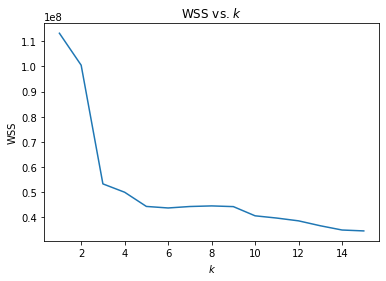

In [ ]:
# The number of max k value to find the optimal k for k-means clustering.
K_MAX = 15

sse = []

for k in range(1, K_MAX+1):
    kmeans = ts.TimeSeriesKMeans(n_clusters=k, random_state=1).fit(X)
    centroids = kmeans.cluster_centers_
    clusters = kmeans.predict(X)
    print('The shape of the cluster centers for k =', str(k))
    print(kmeans.cluster_centers_.shape)
    curr_sse = 0

    # Calculate square of Euclidean distance of each point from its cluster
    # center and add to current WSS.
    for i in range(len(X)):
      curr_center = centroids[clusters[i]]
      curr_sse += (X[i, 0] - curr_center[0]) ** 2 + \
        (X[i, 1] - curr_center[1]) ** 2
      
    sse.append(curr_sse)

plt.plot(range(1, K_MAX+1), sse)
plt.title('WSS vs. $k$')
plt.xlabel('$k$')
plt.ylabel('WSS')
plt.show()

Based on the elbow bend plot, we decided that K = 5


In [ ]:
K = 5
kmeans = ts.TimeSeriesKMeans(n_clusters=K, random_state=1)
labels = kmeans.fit_predict(X)
num_clusters = K
cluster_centers = kmeans.cluster_centers_
#exported_file = kmeans.to_json("./model_1.json")

The shape of the cluster centers: (5, 248, 1)


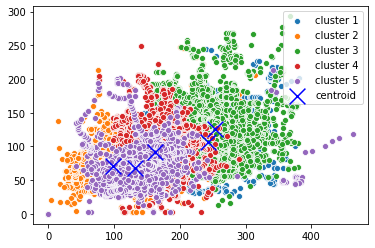

In [ ]:
print('The shape of the cluster centers:', cluster_centers.shape)
for cluster_num in range(num_clusters):
    sns.scatterplot(
          x=X[labels == cluster_num, 0], y=X[labels == cluster_num, 1]
      )

plt.scatter(
    x=cluster_centers[:, 0], y=cluster_centers[:, 1],
    s=250, marker='x', c='blue'
)

plt.legend(['cluster 1', 'cluster 2', 'cluster 3', 'cluster 4', 'cluster 5','centroid'])
plt.show()

Calculating the Size of each cluster

In [ ]:
cluster_one = 0
cluster_two = 0
cluster_thr = 0
cluster_for = 0
cluster_fiv = 0


for i in labels:
  if i == 0:
    cluster_one += 1
  elif i == 1:
    cluster_two += 1
  elif i == 2:
    cluster_thr += 1
  elif i == 3:
    cluster_for += 1
  elif i == 4:
    cluster_fiv += 1

print(f"cluster 1:{cluster_one}")
print(f"cluster 2:{cluster_two}")
print(f"cluster 3:{cluster_thr}")
print(f"cluster 4:{cluster_for}")
print(f"cluster 5:{cluster_fiv}")

cluster 1:3250
cluster 2:3229
cluster 3:3692
cluster 4:4733
cluster 5:2296


Finding the nearest Datapoint to each centroid of each cluster

In [ ]:
from sklearn.metrics import pairwise_distances_argmin_min
closest_datapoints, _ = pairwise_distances_argmin_min(cluster_centers.reshape(5,248), X)
print('The closest points to each centroids are', closest_datapoints)

The closest points to each centroids are [16848  5403 15663 10578  4140]


In [ ]:
closest_datapoints_df = pd.DataFrame().reindex_like(n_df_poses).iloc[0:0]

for closest_point in closest_datapoints:
    gif = n_df_poses.loc[[closest_point]]
    closest_datapoints_df = closest_datapoints_df.append(gif)

closest_datapoints_df

,x_Nose,y_Nose,x_Neck,y_Neck,x_RShoulder,y_RShoulder,x_RElbow,y_RElbow,x_RWrist,y_RWrist,x_LShoulder,y_LShoulder,x_LElbow,y_LElbow,x_LWrist,y_LWrist,x_REye,y_REye,x_LEye,y_LEye,x_REar,y_REar,x_LEar,y_LEar,x_0_lhand,y_0_lhand,x_1_lhand,y_1_lhand,x_2_lhand,y_2_lhand,x_3_lhand,y_3_lhand,x_4_lhand,y_4_lhand,x_5_lhand,y_5_lhand,x_6_lhand,y_6_lhand,x_7_lhand,y_7_lhand,...,y_51,x_52,y_52,x_53,y_53,x_54,y_54,x_55,y_55,x_56,y_56,x_57,y_57,x_58,y_58,x_59,y_59,x_60,y_60,x_61,y_61,x_62,y_62,x_63,y_63,x_64,y_64,x_65,y_65,x_66,y_66,x_67,y_67,x_68,y_68,x_69,y_69,sample,emotion,frame
16848,246.7200,107.1180,245.2190,216.7410,146.1540,216.7100,138.6730,359.388,188.2440,236.247,344.360,219.721,353.417,344.376,306.798,215.248,228.7300,90.6517,261.8030,90.6099,207.6820,111.5650,282.754,105.5860,321.631,206.771,311.558,194.460,288.615,188.305,276.304,174.315,279.102,168.719,299.807,183.268,287.496,182.149,290.294,216.284,...,123.7780,250.1590,122.0780,256.5330,123.7780,261.2070,126.3270,256.9570,132.7010,251.0090,135.6760,246.3350,136.1000,240.3860,135.6760,234.0120,132.7010,231.4620,128.4520,240.386,128.4520,246.3350,128.8770,250.5840,128.4520,259.0820,127.6020,250.5840,128.4520,246.3350,128.8770,240.3860,128.4520,228.063,92.7589,261.6320,92.7589,251,happiness,3.0
5403,82.7668,67.5326,76.6877,131.5800,18.0170,137.6340,0.0000,0.000,0.0000,0.000,131.527,130.762,0.000,0.000,0.000,0.000,70.5844,54.5821,94.9974,56.8611,51.5360,63.7132,112.458,64.5036,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,77.8256,85.0276,76.9450,89.4309,78.7063,93.8342,81.0547,89.4309,83.6967,85.0276,84.5773,82.0921,84.8709,77.9824,84.5773,73.5791,83.6967,70.9371,80.7611,78.863,79.2934,82.0921,79.8805,85.0276,79.8805,91.7793,81.0547,85.0276,81.6418,82.0921,81.9353,78.5695,81.6418,70.350,55.5156,94.7149,56.9834,158,fear,34.0
15663,246.1340,130.3840,253.8810,228.8960,150.6690,230.4330,0.0000,0.000,0.0000,0.000,355.613,228.858,0.000,0.000,0.000,0.000,227.3210,105.3350,269.5250,106.8160,203.8740,111.5830,300.837,113.1020,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,145.3610,254.9560,144.4220,262.9370,143.4830,270.9180,145.3610,263.8760,155.2190,255.8950,160.3830,248.3840,160.8530,241.8120,160.3830,234.7700,155.2190,232.8920,145.3610,243.690,146.3000,248.3840,148.1780,255.4260,146.7690,267.6310,145.8300,255.8950,153.3410,248.3840,155.2190,241.8120,153.8110,226.320,107.3360,269.9790,107.3360,46,happiness,0.0
10578,154.2160,93.3077,142.0390,146.7000,51.1107,145.7490,0.0000,0.000,0.0000,0.000,230.139,142.973,0.000,0.000,0.000,0.000,136.4140,77.3725,168.3130,72.6665,93.2566,66.1067,186.099,76.4224,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,105.3580,165.9390,103.9570,169.3020,103.1170,172.9460,101.7150,171.2640,105.6390,168.7420,107.6000,167.0600,109.5620,164.8180,110.6830,162.2960,113.2050,159.7740,113.4860,163.137,108.4410,165.0990,107.3200,166.7800,105.6390,171.5440,102.5560,166.7800,105.6390,165.3790,107.3200,163.4170,109.0020,135.953,78.4549,169.3020,73.9710,226,sadness,78.0
4140,124.9480,55.1773,112.2540,92.4698,78.9633,91.6338,43.3038,135.233,65.4798,117.802,147.120,95.612,155.834,147.127,167.718,125.717,117.8150,48.8761,129.6800,48.8713,104.3360,57.5653,135.233,54.4176,176.623,130.343,175.281,124.976,166.656,115.201,161.673,116.160,158.415,114.051,166.656,116.160,163.398,116.351,160.331,116.735,...,63.0581,125.6810,62.9027,127.8570,63.9906,129.2560,65.7002,128.0120,69.2746,126.7690,70.6733,125.6810,70.8288,124.4380,70.6733,122.4170,69.7409,121.0190,67.5651,123.194,64.3014,124.5930,64.3014,125.5260,64.3014,128.7890,65.7002,126.6140,69.1192,125.5260,69.2746,124.4380,69.2746,118.532,49.5373,127.5460,48.1386,12,surprise,81.0


# KNN Testing

Need to label some gifs manually with social signal combined_df or preprocessed will be our X

Our Y will be 'is_social_signal' one eg. combined_df['is_social_signal'] after labelling

-Randomly pick from our combined dataset

-Randint -> 0-happiness 1-sadness 2-surprise 3-fear

-Choose 60 and pick first 15 social signals and 15 non social signal gifs

-Remove any duplicates

In [ ]:
seed(1)
emotions = ['happiness', 'sadness', 'surprise', 'fear']

#Grab number of files in each emotion folder
emotion_files_count = [
               os.listdir(directory + '/' + emotions[0]),
               os.listdir(directory + '/' + emotions[1]),
               os.listdir(directory + '/' + emotions[2]),
               os.listdir(directory + '/' + emotions[3]),     
]

for i in range(60):
  random_emotion_index = randint(0,len(emotions)-1)
  random_emotion_file_index = randint(0,len(emotion_files_count[random_emotion_index])-1)
  #print(emotions[random_emotion_index] + ": " + emotion_files_count[random_emotion_index][random_emotion_file_index])

Remake a new dataframe for testing

In [ ]:
def read_specific_gif_data(emotion_path, sample_path):
    
    df_pose_local = pd.DataFrame()
    df_face_local = pd.DataFrame()
    df_lhand_local = pd.DataFrame()
    df_rhand_local = pd.DataFrame()

    file_path = f"{directory}/{emotion_path}/{sample_path}"
    # Pose
    df_pose_local = pd.read_csv(f"{file_path}/pose.csv")
    df_pose_local.drop("Unnamed: 0", axis=1, inplace=True)
    df_pose_local[sample_label] = sample
    df_pose_local[emotion_label] = emotion
    
    # Face
    df_face_local = pd.read_csv(file_path + "/face.csv")
    df_face_local.drop("Unnamed: 0", axis=1, inplace=True)
    df_face_local[sample_label] = sample
    df_face_local[emotion_label] = emotion

    # Left Hand
    df_lhand_local = pd.read_csv(file_path + "/hand_left.csv")
    df_lhand_local.drop("Unnamed: 0", axis=1, inplace=True)
    df_lhand_local[sample_label] = sample
    df_lhand_local[emotion_label] = emotion

    # Right Hand
    df_rhand_local = pd.read_csv(file_path + "/hand_right.csv")
    df_rhand_local.drop("Unnamed: 0", axis=1, inplace=True)
    df_rhand_local[sample_label] = sample
    df_rhand_local[emotion_label] = emotion

    return df_pose_local, df_face_local, df_lhand_local, df_rhand_local

Using 15 gifs with smiling + Peace sign : Happiness 220, 221, 222, 223,224,225,226,227, 228, 229, 230, 231, 232, 233, 234

And 15 gifs without

In [ ]:
# 15 with smiling + pce sign Happiness 220, 221, 222, 223,224,225,226,227, 228, 229, 230, 231, 232, 233, 234

# Input GIF KNN Validation Training set here
# Add the GIF number into the arrays that include social signals or don't
# Keep in mind that you will need to supply at least one for social_signals and no_social_signals or else further down code will fail
happiness_social_signals = [220, 249, 251, 223,244,238,226,177, 235, 102, 240, 241, 248, 53, 234]
sadness_social_signals = []
surprise_social_signals = []
fear_social_signals = []
social_signals = [happiness_social_signals, sadness_social_signals, surprise_social_signals, fear_social_signals]

happiness_no_social_signals = []
sadness_no_social_signals = [13,32,33,26,15,9,1,141,148,145,207,221,219,229,228]
surprise_no_social_signals = []
fear_no_social_signals = []
no_social_signals = [happiness_no_social_signals, sadness_no_social_signals, surprise_no_social_signals, fear_no_social_signals]

In [ ]:
#Create data frame of dataset
df_pose_training = pd.DataFrame()
df_face_training = pd.DataFrame()
df_lhand_training = pd.DataFrame()
df_rhand_training = pd.DataFrame()

for i in range(len(social_signals)):
  for sample in social_signals[i]:
    temp_pose_df, temp_face_df, temp_lhand_df, temp_rhand_df = read_specific_gif_data("happiness", sample)
    df_pose_training = pd.concat([df_pose_training, temp_pose_df])
    df_face_training = pd.concat([df_face_training, temp_face_df])
    df_lhand_training = pd.concat([df_lhand_training, temp_lhand_df])
    df_rhand_training = pd.concat([df_rhand_training, temp_rhand_df])

# Add frame labels
df_pose_training = preprocess(df_pose_training)
df_face_training = preprocess(df_face_training)
df_lhand_training = preprocess(df_lhand_training)
df_rhand_training = preprocess(df_rhand_training)

# Combine into a singular db of social signals
social_signal_df = combine_openpose_dfs(df_pose_training, df_face_training, df_lhand_training, df_rhand_training)

# Remove unnecessary columns
social_signal_df = social_signal_df.drop([emotion_label, sample_label ,frame_label], axis=1)
social_signal_df = Second_preprocess(social_signal_df)

# Add social signal column (Do note, that we originally had 251 columns and now we have 252 because of the is_social_signal column)
social_signal_df["is_social_signal"] = 1


Making the testing dataframes

In [ ]:
#Reset data from temporary dfs
df_pose_training = pd.DataFrame()
df_face_training = pd.DataFrame()
df_lhand_training = pd.DataFrame()
df_rhand_training = pd.DataFrame()

for i in range(len(no_social_signals)):
  for sample in no_social_signals[i]:
    temp_pose_df, temp_face_df, temp_lhand_df, temp_rhand_df = read_specific_gif_data("fear", sample)
    df_pose_training = pd.concat([df_pose_training, temp_pose_df])
    df_face_training = pd.concat([df_face_training, temp_face_df])
    df_lhand_training = pd.concat([df_lhand_training, temp_lhand_df])
    df_rhand_training = pd.concat([df_rhand_training, temp_rhand_df])

# Add frame labels
df_pose_training = preprocess(df_pose_training)
df_face_training = preprocess(df_face_training)
df_lhand_training = preprocess(df_lhand_training)
df_rhand_training = preprocess(df_rhand_training)

# Combine into a singular db of non social signals
no_social_signal_df = combine_openpose_dfs(df_pose_training, df_face_training, df_lhand_training, df_rhand_training)


# Remove unnecessary columns
no_social_signal_df = no_social_signal_df.drop([emotion_label, sample_label ,frame_label], axis=1)
no_social_signal_df = Second_preprocess(no_social_signal_df)

# Add social signal column
no_social_signal_df["is_social_signal"] = 0

#display(no_social_signal_df)

In [ ]:
targeted_gif_df = pd.concat([social_signal_df, no_social_signal_df])
display(targeted_gif_df)

,x_Nose,y_Nose,x_Neck,y_Neck,x_RShoulder,y_RShoulder,x_RElbow,y_RElbow,x_RWrist,y_RWrist,x_LShoulder,y_LShoulder,x_LElbow,y_LElbow,x_LWrist,y_LWrist,x_REye,y_REye,x_LEye,y_LEye,x_REar,y_REar,x_LEar,y_LEar,x_0,y_0,x_1,y_1,x_2,y_2,x_3,y_3,x_4,y_4,x_5,y_5,x_6,y_6,x_7,y_7,...,y_1_rhand,x_2_rhand,y_2_rhand,x_3_rhand,y_3_rhand,x_4_rhand,y_4_rhand,x_5_rhand,y_5_rhand,x_6_rhand,y_6_rhand,x_7_rhand,y_7_rhand,x_8_rhand,y_8_rhand,x_9_rhand,y_9_rhand,x_10_rhand,y_10_rhand,x_11_rhand,y_11_rhand,x_12_rhand,y_12_rhand,x_13_rhand,y_13_rhand,x_14_rhand,y_14_rhand,x_15_rhand,y_15_rhand,x_16_rhand,y_16_rhand,x_17_rhand,y_17_rhand,x_18_rhand,y_18_rhand,x_19_rhand,y_19_rhand,x_20_rhand,y_20_rhand,is_social_signal
0,186.783,104.150,240.738,174.648,161.191,207.686,0.0,0.0,0.0,0.0,318.828,146.121,375.915,260.291,0.0,0.0,170.195,101.0990,197.269,81.5584,161.156,114.574,233.218,80.0779,158.7480,113.477,163.6540,120.646,169.314,128.571,175.351,135.363,182.143,141.023,191.199,144.041,200.256,146.683,209.689,147.815,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,188.178,104.085,240.768,174.647,162.650,207.698,0.0,0.0,0.0,0.0,318.826,144.664,377.353,258.809,0.0,0.0,171.633,99.6230,198.651,80.1184,162.617,113.113,233.261,80.1007,160.0610,114.092,165.1470,122.308,169.450,128.959,176.102,135.610,183.535,141.087,191.360,144.217,200.358,147.347,209.748,147.739,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,188.183,104.106,242.238,174.650,161.201,207.734,0.0,0.0,0.0,0.0,318.866,146.151,377.358,260.255,0.0,0.0,171.626,99.6156,198.664,80.0899,161.187,113.030,233.283,80.0887,159.4130,112.728,163.9430,119.899,168.472,127.826,174.889,134.997,182.815,140.282,190.364,144.433,199.045,147.453,209.614,149.340,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,189.703,104.094,240.767,173.208,161.195,204.729,0.0,0.0,0.0,0.0,318.826,144.630,378.851,258.806,0.0,0.0,171.685,99.5866,198.751,80.0838,162.606,113.108,233.309,80.0798,160.3130,114.563,164.1900,121.929,169.618,128.520,175.045,135.111,182.024,140.926,189.390,145.967,197.919,149.068,207.224,150.231,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,192.675,102.684,239.246,174.719,161.128,209.208,0.0,0.0,0.0,0.0,318.860,144.672,380.396,258.782,0.0,0.0,173.141,101.0470,200.185,80.1428,162.664,114.685,234.685,80.0881,158.7720,112.824,163.8810,119.899,168.205,128.152,174.100,135.620,181.568,141.908,189.821,147.411,198.861,150.948,209.079,151.734,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1098,217.617,176.438,0.000,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.0,0.0,172.682,135.2380,263.782,104.0710,0.000,0.000,313.631,95.3357,0.0000,0.000,0.0000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1099,222.551,181.404,0.000,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.0,0.0,148.960,115.3400,267.478,105.3360,111.529,147.721,311.165,109.0510,87.9868,134.578,93.8045,171.424,105.440,203.421,124.832,231.540,150.042,252.872,175

Split the testing data into 80-20 for training and testing subsets

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
X = targeted_gif_df
y = targeted_gif_df['is_social_signal']

# Split the dataset into train (80%) and test (20%) subsets.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0
)

#print('# of X_train data:', len(X_train))
#print('# of X_test data:', len(X_test))
#print('# of y_train data:', len(y_train))
#print('# of y_test data:', len(y_test))

k-Fold Cross-Validation and k-Nearest Neighbours 

We decided to use 5 folds for cross validation

In [ ]:
# Create a new k-NN model with k = 1.
knn_cv = KNeighborsClassifier(n_neighbors=1)

# Examine k-NN alone.
knn_cv.fit(X_train, y_train)
y_pred = knn_cv.predict(X_test)
print('k-NN Accuracy (without Cross-Validation):', knn_cv.score(X_test, y_test))

# Train model with a cross-validation (CV) generator with 5 folds. Note: the 
# CV generator uses `sklearn.model_selection.StratifiedKFold`.
cv_scores = cross_val_score(knn_cv, X, y, cv=5)

print('Cross-Validation Scores:', cv_scores)
print('Mean Cross-Validation Score:{}'.format(np.mean(cv_scores)))

k-NN Accuracy (without Cross-Validation): 0.9969325153374233
Cross-Validation Scores: [0.93865031 0.89263804 0.92638037 0.62269939 0.78527607]
Mean Cross-Validation Score:0.8331288343558281
